In [16]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
def train_and_tune_and_evaluate_model(X, y, model, param_grid, standardize=True, resample=True, scoring='recall', cv=5, random_state=42):
    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Standardize features
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Apply SMOTE to the scaled training data
    if resample:
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Combine the model and scaler into a single pipeline
    pipe = [('scaler', StandardScaler()), ('model', model)] if standardize else [('model', model)]
    pipeline = Pipeline(pipe)

    # Create the GridSearchCV object with StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=stratified_cv)
    grid_search.fit(X_train, y_train)

    # Extracting the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate on multiple metrics using the scaled test data
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]

    scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'auc_roc': roc_auc_score(y_test, y_scores)
    }

    # Plotting the performance of various parameter combinations
    results = pd.DataFrame(grid_search.cv_results_)
    for param in param_grid:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x=f'param_{param}', y='mean_test_score')
        plt.title(f'Performance for different values of {param}')
        plt.ylabel(scoring)
        plt.xlabel(param)
        plt.show()

    print("Best Model:", best_model)
    print("Scores:", scores)
    print("Best Params:", best_params)

    return best_model, scores, best_params

In [3]:
df = pd.read_csv('data.csv')
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

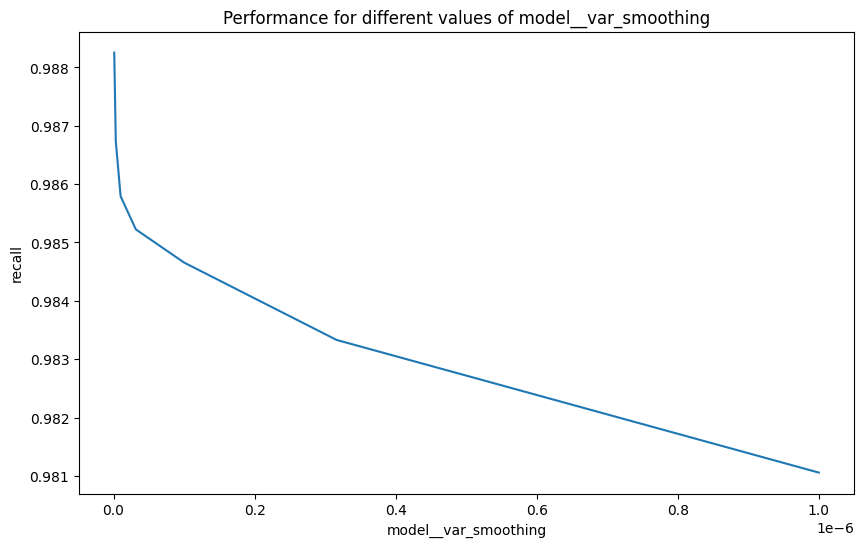

Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())])
Scores: {'accuracy': 0.2932551319648094, 'confusion_matrix': array([[363, 957],
       [  7,  37]]), 'recall': 0.8409090909090909, 'auc_roc': 0.6450241046831956}
Best Params: {'model__var_smoothing': 1e-09}


(Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())]),
 {'accuracy': 0.2932551319648094,
  'confusion_matrix': array([[363, 957],
         [  7,  37]]),
  'recall': 0.8409090909090909,
  'auc_roc': 0.6450241046831956},
 {'model__var_smoothing': 1e-09})

In [4]:
# GNB
param_grid_gnb = {
    'model__var_smoothing': np.logspace(-9, -6, 7)
}

train_and_tune_and_evaluate_model(X, y, GaussianNB(), param_grid_gnb)

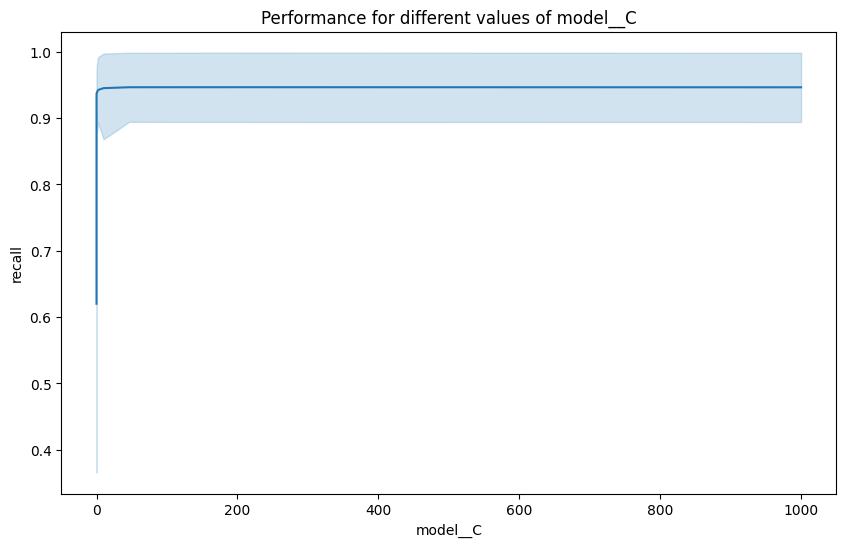

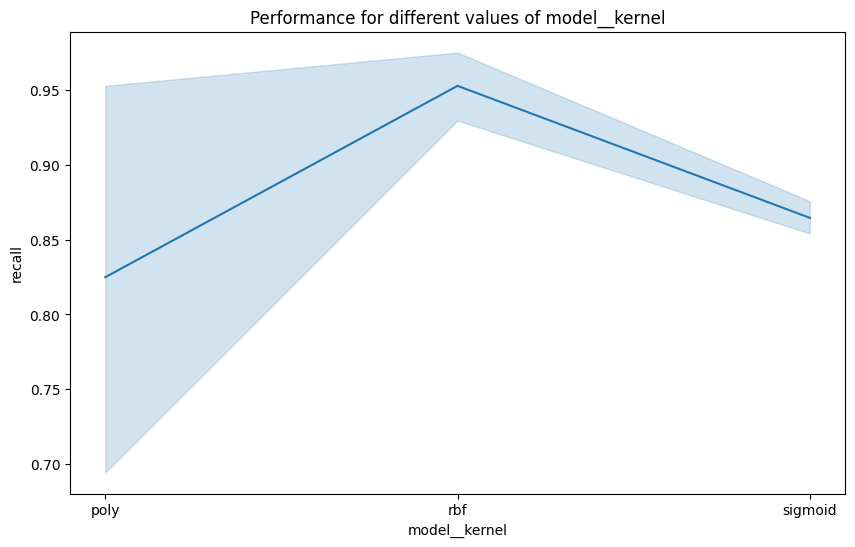

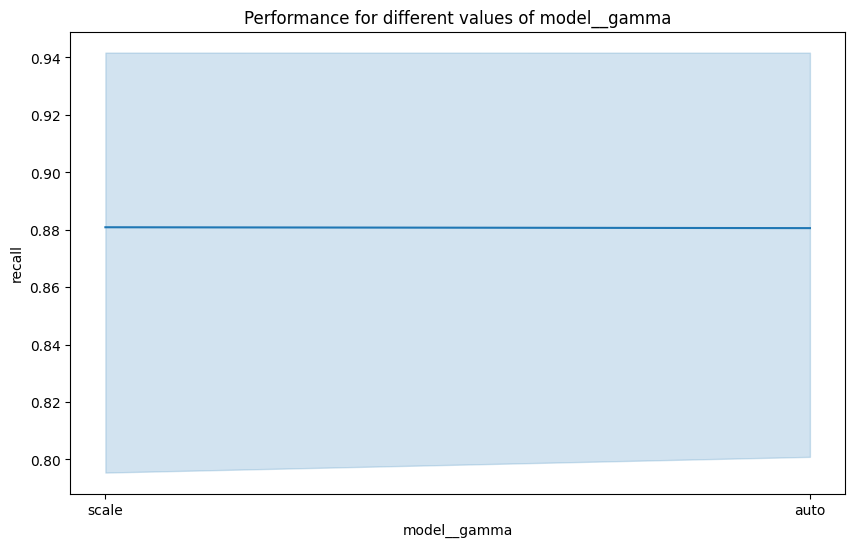

Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=46.41588833612773, probability=True))])
Scores: {'accuracy': 0.9596774193548387, 'confusion_matrix': array([[1291,   29],
       [  26,   18]]), 'recall': 0.4090909090909091, 'auc_roc': 0.8200068870523416}
Best Params: {'model__C': 46.41588833612773, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


In [19]:
# SVM
param_grid_svm = {
    'model__C': np.logspace(-3, 3, 10),
    'model__kernel': ['poly', 'rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto']
}

best_model, scores, best_params = train_and_tune_and_evaluate_model(X, y, SVC(probability=True), param_grid_svm)


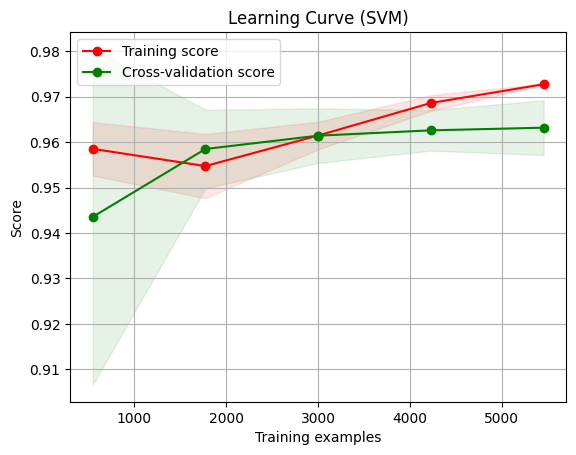

In [20]:
# 繪製學習曲線
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(best_model.named_steps['model'], "Learning Curve (SVM)", X, y)